# Analyze Chinook database using SQL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline 

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)    
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table", "view");
    '''
    return run_query(q)
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## 1. Find out which genres sell the best in the USA

In [3]:
q1 = '''
WITH track_purchases AS(
    SELECT 
        SUM(invoice_line.quantity) as purchases,
        track.name as track,
        genre.name as genre
    FROM invoice_line
    LEFT JOIN track ON invoice_line.track_id = track.track_id
    LEFT JOIN genre ON track.genre_id = genre.genre_id
    GROUP BY 2)
SELECT 
    genre,
    SUM(purchases) AS total_purchases,
    ROUND(SUM(CAST(purchases AS FLOAT) / CAST(
        (SELECT SUM(purchases) FROM track_purchases) 
        AS FLOAT)) * 100, 2) AS "total_purchases(%)"
FROM track_purchases
GROUP BY genre
ORDER BY 2 DESC
'''
best_selling_genre = run_query(q1)
best_selling_genre


,genre,total_purchases,total_purchases(%)
0,Rock,2624,55.16
1,Metal,625,13.14
2,Alternative & Punk,490,10.30
3,Latin,167,3.51
4,R&B/Soul,159,3.34
5,Jazz,128,2.69
6,Blues,123,2.59
7,Alternative,119,2.50
8,Easy Listening,74,1.56
9,Pop,63,1.32


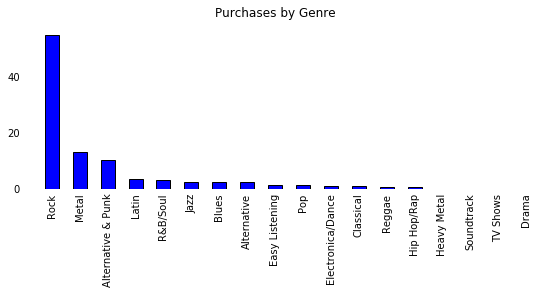

In [4]:
fig1, ax = plt.subplots(figsize=(9,3))
positions = np.arange(best_selling_genre.shape[0])+0.75
xticks = positions + 0.25
ax.bar(positions, best_selling_genre['total_purchases(%)'], 0.5)
ax.set_xticks(xticks)
ax.set_yticks(np.arange(0,60,20))
ax.set_xlim(0,18)
ax.set_xticklabels(best_selling_genre['genre'], rotation=90)
ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.axhline(0, alpha=0.3)
ax.set_title('Purchases by Genre')
for i, spine in ax.spines.items():
    spine.set_visible(False)

### Based on the analysis, Rock and Metal are the best selling genres. From the four new albums, I would recommend Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop).

## 2. Find out which employees are the best salespersons

In [5]:
q2 = '''
SELECT 
    employee.first_name || " " || employee.last_name AS employee,
    employee.title,
    SUM(invoice.total) AS total_sales
FROM employee
LEFT JOIN customer ON employee.employee_id = customer.support_rep_id
LEFT JOIN invoice ON customer.customer_id = invoice.customer_id
GROUP BY employee.employee_id
ORDER BY 3 DESC
'''
sales_by_employee = run_query(q2)
sales_by_employee

,employee,title,total_sales
0,Jane Peacock,Sales Support Agent,1731.51
1,Margaret Park,Sales Support Agent,1584.00
2,Steve Johnson,Sales Support Agent,1393.92
3,Andrew Adams,General Manager,NaN
4,Nancy Edwards,Sales Manager,NaN
5,Michael Mitchell,IT Manager,NaN
6,Robert King,IT Staff,NaN
7,Laura Callahan,IT Staff,NaN


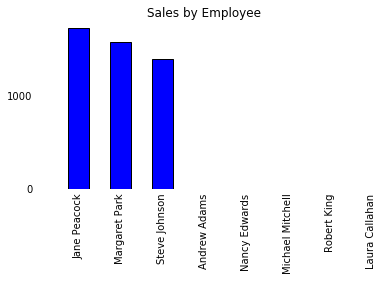

In [6]:
fig2, ax = plt.subplots(figsize=(6,3))
positions = np.arange(sales_by_employee.shape[0])+0.75
xticks = positions + 0.25
ax.bar(positions, sales_by_employee['total_sales'], 0.5)
ax.set_xticks(xticks)
ax.set_yticks(np.arange(0,2000,1000))
ax.set_xlim(0,8)
ax.set_xticklabels(sales_by_employee['employee'], rotation=90)
ax.tick_params(bottom="off", top="off", left="off", right="off")
ax.axhline(0, alpha=0.3)
ax.set_title('Sales by Employee')
for i, spine in ax.spines.items():
    spine.set_visible(False)

### The results are self-explanatory. Sales support agents sell the best. Managers and IT technicians do not directly sell.

## 3. Analyze sales data from each country 

In [7]:
# create a view/temporary table grouped by customer 
c1 = '''
CREATE VIEW by_customer AS
    SELECT 
        c.customer_id,
        c.country,
        SUM(i.total) as sales_per_customer
    FROM customer AS c
    LEFT JOIN invoice as i ON c.customer_id = i.customer_id
    GROUP BY 1
    ORDER BY 3 DESC;        
'''
run_command(c1)

OperationalError: table by_customer already exists

In [8]:
q4 = '''
SELECT * FROM by_customer LIMIT 5;
'''
run_query(q4)

,customer_id,country,sales_per_customer
0,5,Czech Republic,144.54
1,6,Czech Republic,128.70
2,46,Ireland,114.84
3,58,India,111.87
4,1,Brazil,108.90


In [9]:
# group by_customer by each country to get the total number of customers, total value of sales, and average value of sales per customer
# then join another column that calcualtes the average order value by country 
q5 = '''
WITH all_data AS
(
WITH 
    last_col AS(
        SELECT
            AVG(i.total) AS "average order value",
            c.country
        FROM customer as c
        LEFT JOIN invoice as i on c.customer_id = i.customer_id
        GROUP BY 2)
    
SELECT 
    b.country,
    COUNT(b.customer_id) AS "total number of customers",
    SUM(b.sales_per_customer) AS "total value of sales",
    AVG(b.sales_per_customer) AS "average value of sales per customer",
    l."average order value"
FROM by_customer as b
INNER JOIN last_col as l ON l.country = b.country
GROUP BY 1
ORDER BY 3 DESC
)

SELECT 
    country_name AS country,
    SUM("total number of customers") AS "total number of customers",
    SUM("total value of sales") AS "total value of sales",
    AVG("average value of sales per customer") AS "average value of sales per customer",
    AVG("average order value") AS "average order value"
FROM (
    SELECT 
        *,
        CASE 
            WHEN "total number of customers" = 1 THEN "Other"
            ELSE country
            END 
            AS country_name,
        CASE 
            WHEN "total number of customers" = 1 THEN 0
            ELSE 1
            END 
            AS other_boolean
    FROM all_data
    )
GROUP BY 1
ORDER BY other_boolean DESC, 3 DESC
'''
sales_by_country = run_query(q5)
sales_by_country


,country,total number of customers,total value of sales,average value of sales per customer,average order value
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,Czech Republic,2,273.24,136.620000,9.108000
6,United Kingdom,3,245.52,81.840000,8.768571
7,Portugal,2,185.13,92.565000,6.383793
8,India,2,183.15,91.575000,8.721429
9,Other,15,1094.94,72.996000,7.445071


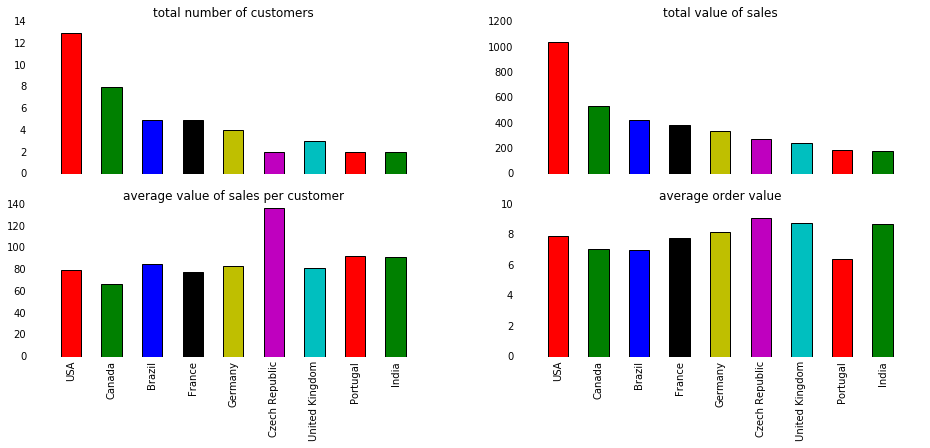

In [10]:
fig = plt.figure(figsize=(16, 6))
plot_list = sales_by_country.columns[1:5]
sales_by_country = sales_by_country.loc[:8,:]
for i, item in enumerate(plot_list):
    ax = fig.add_subplot(2,2,i%2+i//2*2+1)
    positions = np.arange(sales_by_country.shape[0])+0.75
    xticks = positions + 0.25
    ax.bar(positions, sales_by_country[item], 0.5, color='rgbkymc')
    ax.set_xticks(xticks)
#    ax.set_yticks(np.arange(0,2000,1000))
    ax.set_xlim(0,10)
    ax.set_xticklabels(sales_by_country['country'], rotation=90)
    ax.tick_params(bottom="off", top="off", left="off", right="off")
    ax.axhline(0, alpha=0.3)
    ax.set_title(item)
    for j, spine in ax.spines.items():
        spine.set_visible(False)
    if i in [0,1]:
        x_axis = ax.axes.get_xaxis()
        x_axis.set_visible(False)



### USA has the most customers and thus the most revenue. However, Czech Republic and other European countries have customers purchasing more expensive orders. Sales people can target these countries and attract more customers. 

## 4. Categorize each invoice as either an album purchase or not

In [13]:
# first create a table of tracks for each invoice
c2 = '''
CREATE VIEW invoice_tracklist AS 
SELECT
    i.invoice_id,
    t.track_id
FROM invoice as i
INNER JOIN invoice_line ON i.invoice_id = invoice_line.invoice_id
INNER JOIN track as t ON invoice_line.track_id = t.track_id;
'''
run_command(c2)

q6 = '''
SELECT * FROM invoice_tracklist;
'''
run_query(q6)


,invoice_id,track_id
0,1,1158
1,1,1159
2,1,1160
3,1,1161
4,1,1162
5,1,1163
6,1,1164
7,1,1165
8,1,1166
9,1,1167


In [14]:
# second create a table of tracks within each album
c3 = '''
CREATE VIEW album_tracklist AS
SELECT 
    a.album_id,
    t.track_id
FROM album as a
INNER JOIN track as t ON t.album_id = a.album_id;
'''
run_command(c3)

q7 = '''
SELECT * FROM album_tracklist;
'''
run_query(q7)

,album_id,track_id
0,1,1
1,1,6
2,1,7
3,1,8
4,1,9
5,1,10
6,1,11
7,1,12
8,1,13
9,1,14


In [19]:
# select each invoice, and use its first track to select the correponding album, 
# and compare if the list of tracks in the invoice is the same as the list of tracks from the album

# q8 relates each invoice with the possible album to compare with
c4 = '''
CREATE VIEW invoice_album AS

WITH invoice_group AS(
    SELECT * 
    FROM invoice_tracklist as i
    GROUP BY i.invoice_id)
SELECT 
    invoice_group.invoice_id,
    album_tracklist.album_id
FROM invoice_group
LEFT JOIN album_tracklist ON invoice_group.track_id = album_tracklist.track_id;
'''

run_command(c4)

q8 ='''
SELECT * FROM invoice_album;
'''
run_query(q8)

,invoice_id,album_id
0,1,91
1,2,215
2,3,214
3,4,203
4,5,163
5,6,5
6,7,6
7,8,125
8,9,20
9,10,257


In [23]:
# now create a view with the entire album list to compare with the invoice list
c5 = '''
CREATE VIEW invoice_albumtracks AS
    SELECT 
        invoice_album.invoice_id,
        album_tracklist.track_id AS album_track
    FROM invoice_album
    INNER JOIN album_tracklist ON invoice_album.album_id = album_tracklist.album_id;
'''
run_command(c5)
q9 = '''
SELECT * FROM invoice_albumtracks
'''
run_query(q9)

,invoice_id,album_track
0,1,1158
1,1,1159
2,1,1160
3,1,1161
4,1,1162
5,1,1163
6,1,1164
7,1,1165
8,1,1166
9,1,1167


In [27]:
# now use invoice_id, to compare the track_lists from 
# table view 1: invoice_tracklist (column "track_id")
# table view 2: invoice_albumtracks (column "album_track")

q10 = '''
SELECT 
    invoice_album.invoice_id,
    CASE 
        WHEN 
            (
            SELECT track_id FROM invoice_tracklist
            WHERE invoice_tracklist.invoice_id = invoice_album.invoice_id
            EXCEPT 
            SELECT album_track FROM invoice_albumtracks
            WHERE invoice_albumtracks.invoice_id = invoice_album.invoice_id
            ) IS NULL
            AND
            (
            SELECT album_track FROM invoice_albumtracks
            WHERE invoice_albumtracks.invoice_id = invoice_album.invoice_id
            EXCEPT
            SELECT track_id FROM invoice_tracklist
            WHERE invoice_tracklist.invoice_id = invoice_album.invoice_id
            ) IS NULL
            THEN "yes"
        ELSE "no"
        END
        AS "entire album purchase"
FROM invoice_album;
'''
run_query(q10)


,invoice_id,entire album purchase
0,1,yes
1,2,no
2,3,no
3,4,no
4,5,yes
5,6,no
6,7,no
7,8,no
8,9,no
9,10,no


In [38]:
# at last, calculate the percentage

q11 = '''
WITH entire_album_purchase AS
(
SELECT 
    invoice_album.invoice_id,
    CASE 
        WHEN 
            (
            SELECT track_id FROM invoice_tracklist
            WHERE invoice_tracklist.invoice_id = invoice_album.invoice_id
            EXCEPT 
            SELECT album_track FROM invoice_albumtracks
            WHERE invoice_albumtracks.invoice_id = invoice_album.invoice_id
            ) IS NULL
            AND
            (
            SELECT album_track FROM invoice_albumtracks
            WHERE invoice_albumtracks.invoice_id = invoice_album.invoice_id
            EXCEPT
            SELECT track_id FROM invoice_tracklist
            WHERE invoice_tracklist.invoice_id = invoice_album.invoice_id
            ) IS NULL
            THEN "yes"
        ELSE "no"
        END
        AS "entire album purchase"
FROM invoice_album
)

SELECT 
    "entire album purchase",
    COUNT("entire album purchase") AS "number of invoices",
    ROUND(
    CAST(COUNT("entire album purchase") AS FLOAT) /
    CAST((
    SELECT COUNT(*) FROM entire_album_purchase
    ) AS FLOAT) *100, 2)
    AS "percentage of invoices (%)"
FROM entire_album_purchase
GROUP BY "entire album purchase";

'''
run_query(q11)

,entire album purchase,number of invoices,percentage of invoices (%)
0,no,500,81.43
1,yes,114,18.57


### Entire album purchase accounts for 18.57% of the total purchase. Maybe Chinook store should not continue to buy full albums from record companies, instead just buying the popular tracks.  